# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "TDS" # _ELAISN1
simbad_query = False
radius = 5 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
from astropy.table import unique, Table
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from vasca.tables import TableCollection
from vasca.tables_dict import dd_vasca_columns
from astroquery.simbad import Simbad
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

#prepare file names
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
simbad_fname = "./vasca_pipeline/"+region_name+"/simbad_"+region_name+".fits"

#Simbad.get_field_description('otype')

### Query the data or read from file

In [3]:
#Load region
mt = TableCollection()
if simbad_query:
    # Get region and source coordinates
    rg = Region()
    rg.load_from_fits(region_fname)
    sel_src = rg.tt_sources["sel"]
    tt_src = rg.tt_sources[sel_src]
    src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')

    # Run query
    customSimbad = Simbad()
    customSimbad.add_votable_fields('otype',"otype(opt)","otypes")
    tt_simbad = customSimbad.query_region(src_coord,radius=radius)
    
    # Change type to be handabel by astropy
    tt_simbad["MAIN_ID"] = tt_simbad["MAIN_ID"].data.astype("S32")
    tt_simbad["COO_BIBCODE"] = tt_simbad["COO_BIBCODE"].data.astype("S32")
    tt_simbad["OTYPE"] = tt_simbad["OTYPE"].data.astype("S32")
    tt_simbad["OTYPE_opt"] = tt_simbad["OTYPE_opt"].data.astype("S32")
    tt_simbad["OTYPES"] = tt_simbad["OTYPES"].data.astype("S32")

    # Write simbad and source info into matching tables
    src_idx = tt_simbad["SCRIPT_NUMBER_ID"]-1
    tt_simbad["rg_src_id"] = tt_src[src_idx]["rg_src_id"]
    tu_simbad = unique(tt_simbad, keys='SCRIPT_NUMBER_ID')
    tu_simbad["match_id"] = np.array(range(0,len(tu_simbad)), dtype= np.int32)
    display(tu_simbad)
    
    tt_match = Table(tt_src["rg_src_id","ra","dec","pos_err","obs_filter_id","sel","flux","flux_err","flux_nxv"])
    #tt_match["otype"] = OTYPE_opt
    tt_match.meta["rad"]=str(radius)

    # Add tables to table collection and write
    mt.add_table(tt_match,"tt_match")
    mt.add_table(tu_simbad,"tt_simbad")
    mt.add_table(tt_simbad,"tt_simbad_all")

    #Copy information into tt_match table
    otype = np.array([dd_vasca_columns["otype"]["default"]]*len(tt_match), dtype="S32")
    mt.add_column("tt_match","otype",otype)
    mt.tt_match.add_index("rg_src_id")
    mt_idx = mt.tt_match.loc_indices["rg_src_id", mt.tt_simbad["rg_src_id"]]
    mt.tt_match["otype"][mt_idx] = mt.tt_simbad["OTYPE_opt"]

    #Write collectiion
    mt.write_to_fits(simbad_fname)
else:
    #Load collection
    mt.load_from_fits(simbad_fname) 
display(mt.tt_match[:3])
display(mt.tt_simbad[:3])

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,otype
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],bytes32
8,334.64049826925117,0.4526866937010489,0.09875569,1 .. 2,True,9.525185 .. 5.7065663,0.13788767 .. 0.29823554,0.036390573 .. 0.013060489,QSO
13,334.60403128211425,0.40736589666436374,0.06406002,1 .. 2,True,70.01522 .. 3.1264899,0.19698732 .. 0.23375492,0.00093811314 .. 0.013469439,QSO
34,334.3024804041402,-0.41734493303878567,0.10900603,1 .. 2,True,19.545855 .. 16.19892,0.19674055 .. 0.65612185,0.006314165 .. -0.0027807432,QSO


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,OTYPE_opt,OTYPES,SCRIPT_NUMBER_ID,rg_src_id,match_id
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,,
bytes32,bytes13,bytes13,int16,int16,float32,float32,int16,bytes1,bytes1,bytes32,bytes32,bytes32,bytes32,int32,int32,int32
SDSS J221833.73+002709.2,22 18 33.7383,+00 27 09.244,14,14,0.739,0.787,90,A,O,2020yCat.1350....0G,QSO,QSO,AGN|QSO|QSO|QSO|*|G|G|Opt,1,8,0
2MASS J22182502+0024270,22 18 25.0423,+00 24 26.465,14,14,0.158,0.164,90,A,O,2020yCat.1350....0G,QSO,QSO,QSO|QSO|AGN|QSO|QSO|QSO|NIR|*|*|,2,13,1
SDSS J221712.61-002502.8,22 17 12.6032,-00 25 02.818,14,14,1.843,1.024,90,A,O,2020yCat.1350....0G,QSO,QSO,QSO|AGN|QSO|QSO|AGN|*|Opt|X|X,3,34,2


### Plot found object types

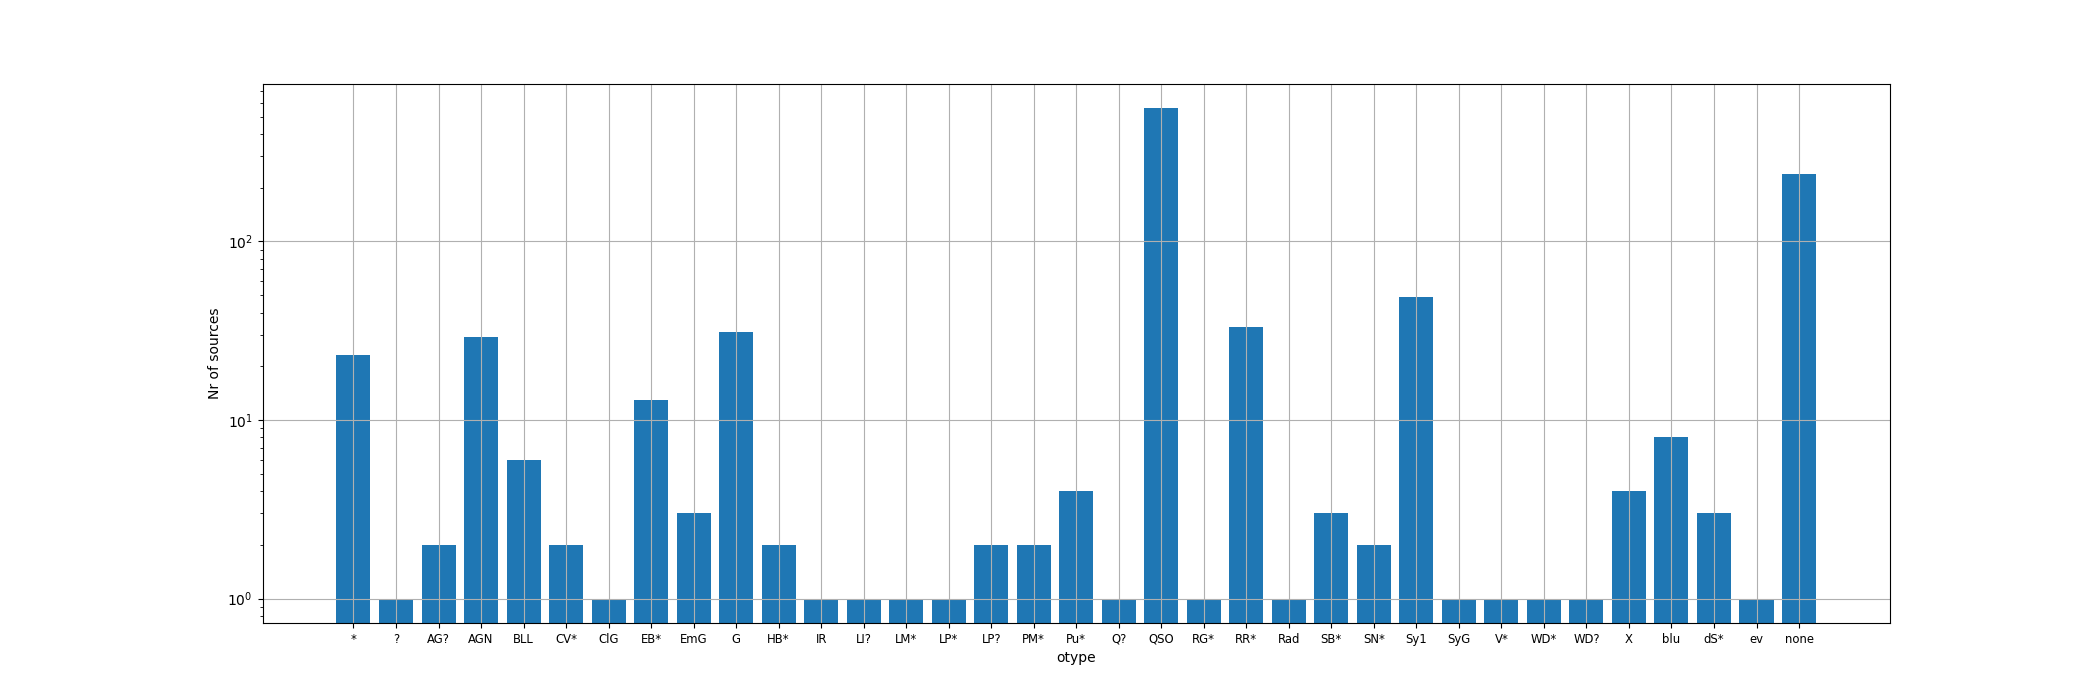

 Id    Label     Candidate       Description                          Category                                          Subcategory                                            Comment                   Status Priority
--- ------------ --------- ------------------------ ------------------------------------------- ------------------------------------------------------------ ------------------------------------------- ------ --------
  *         Star        --                     Star                        1. TAXONOMY OF STARS                                                           --                                          --     --       --
  ?      Unknown        -- Object of Unknown Nature 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --                                          --     --       --
AGN          AGN       AG?    Active Galaxy Nucleus                     4. TAXONOMY OF GALAXIES                                     

In [4]:
otypes, otype_cts= np.unique(mt.tt_match["otype"],return_counts=True)
fig_otypes = plt.figure("Source types",figsize=(21, 7))
plt.bar( range(len(otypes)), otype_cts, align='center')
plt.xticks(range(len(otypes)), otypes, size='small')
plt.yscale('log')
plt.grid()
plt.xlabel("otype")
plt.ylabel("Nr of sources")
plt.show()

tt_nodes = Table.read('./resources/SIMBAD_otypes/otypes_nodes.csv') #, format='ascii.daophot'
ids, ids_idx, _ = np.intersect1d(tt_nodes["Id"],otypes,return_indices=True)
tt_nodes[ids_idx].pprint_all()#show_dtype=True
candidate = np.asarray(np.ma.masked_array(data = tt_nodes["Candidate"],mask = False, fill_value = "none"))
can, can_idx, _ = np.intersect1d(candidate,otypes,return_indices=True)
tt_nodes[can_idx].pprint_all()

### Print all source Ids for a given object type

In [8]:
sel_otype = mt.tt_match["otype"] ==  "LI?" # "SN*" #"EB*"
display(mt.tt_match[sel_otype])
print("srcs_ids = [", end="")
for src_id in mt.tt_match[sel_otype]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

rg_src_id,ra,dec,pos_err,obs_filter_id,sel,flux,flux_err,flux_nxv,otype
,deg,deg,arcsec,,,1e-06 Jy,1e-06 Jy,,
int32,float64,float64,float32,int32[2],bool,float32[2],float32[2],float32[2],bytes32
3227,332.7957627981983,-0.16475899490558057,0.12102689,1 .. 2,True,16.387897 .. 3.5277884,0.20225601 .. 0.47684917,0.008711549 .. -0.031486675,LI?


srcs_ids = [3227 ,]
